# Import libs

In [12]:
import sys
sys.path.append('..\\..')
import gdspy
import numpy as np
from importlib import reload
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator
from QCreator import meshing
from matplotlib import pyplot as plt
reload(gdspy)

<module 'gdspy' from 'C:\\Users\\avasi\\anaconda3\\lib\\site-packages\\gdspy\\__init__.py'>

# Chip parameters, grid

In [13]:
### to have 50 Oms impedance with eps=11.75
tl_core = 10.
tl_gap = 10.
tl_ground = 20.

resonator_core = 10
resonator_gap = 10
resonator_ground = 20

pad_offset = 1100
pad_element_offset = 400
qubit_position_offset = 800

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 320
num_couplers = 1

jc = 0.5e-6 # uA/um^2

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':3,
    'air bridges':2,
    'air bridge pads':1,
    'air bridge sm pads':4,
    'vertical gridlines':15,
    'horizontal gridlines':16,
    'inverted':17,
    'bandages': 25
}

sample = creator.Sample('SrTiO3-resonators-2',layers_configuration,epsilon=15000)


#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=9.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3
central_line_y = sample.chip_geometry.sample_vertical_size/2
chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads, 800)
sample.add(chip_edge_ground)

grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
                                  width=4, period=50)
sample.add(grid_ground)

# Pads

In [14]:
pads_left = []
pads_right = []
for pad_side_id in range(1):
    pad = elements.Pad('pad-left-' + str(pad_side_id),
                       (pad_offset, sample.chip_geometry.sample_vertical_size / 2), np.pi, tl_core,
                       tl_gap, tl_ground,
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                       **elements.default_pad_geometry())
    pads_left.append(pad)
    sample.add(pad)
    pad = elements.Pad('pad-right-' + str(pad_side_id),
                       (sample.chip_geometry.sample_horizontal_size - pad_offset,
                        sample.chip_geometry.sample_vertical_size / 2), 0, tl_core,
                       tl_gap, tl_ground,
                       layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                       **elements.default_pad_geometry())
    pads_right.append(pad)
    sample.add(pad)
    
pads_top = []
pads_bottom = []
for pad_side_id in range(3):
    if pad_side_id != 1:
        pad = elements.Pad('pad-bottom-' + str(pad_side_id),
                           (sample.chip_geometry.sample_horizontal_size / 4 * (pad_side_id + 1), pad_offset),
                           -np.pi / 2, tl_core, tl_gap, tl_ground,
                           layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                           **elements.default_pad_geometry())
        pads_bottom.append(pad)
        sample.add(pad)
        pad = elements.Pad('pad-top-' + str(pad_side_id),
                           (sample.chip_geometry.sample_horizontal_size / 4 * (pad_side_id + 1),
                            sample.chip_geometry.sample_vertical_size - pad_offset),
                           np.pi / 2, tl_core, tl_gap, tl_ground,
                           layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry,
                           **elements.default_pad_geometry())
        pads_top.append(pad)
        sample.add(pad)

    
pad0 = pads_left[0]
pad1 = pads_right[0]
pad2 = pads_top[0]
pad3 = pads_bottom[0]
pad4 = pads_top[1]
pad5 = pads_bottom[1]

# Resonators

In [15]:
sample.connect_cpw(pad0, pad1, port1='port', port2='port', name='right TL', points=[])

[CPW "right TL", l=7500.000]

In [16]:
top1 = (sample.chip_geometry.sample_horizontal_size / 4, 
        sample.chip_geometry.sample_vertical_size - pad_offset - 2635)

top2 = (sample.chip_geometry.sample_horizontal_size / 4 * 3, 
        sample.chip_geometry.sample_vertical_size - pad_offset - 2635)

sample.connect_cpw(pad2, pad4, port1='port', port2='port', name='right TL', points=[top1, top2])

[CPW "right TL", l=9999.823]

In [17]:
bot1 = (sample.chip_geometry.sample_horizontal_size / 4, 
        pad_offset + 385)

bot2 = (sample.chip_geometry.sample_horizontal_size / 4 * 3, 
        pad_offset + 385)

sample.connect_cpw(pad3, pad5, port1='port', port2='port', name='right TL', points=[bot1, bot2])

[CPW "right TL", l=5499.823]

In [18]:
sample.draw_design()
sample.watch()

In [8]:
sample.write_to_gds()

Gds file has been writen here:  C:\Users\avasi\Documents\GitHub\QCreator\designs\SrTiO3_resonators/SrTiO3-resonators-2.gds


# Frequencies

In [19]:
sys, connections, elements_ = sample.get_tls(cutoff=2e9)
f, delta, modes = sys.get_modes()
num_modes=18


In [20]:
f[:num_modes]/(2e6*np.pi), delta[:num_modes]/(2e6*np.pi), f/(2*np.pi*2*delta)

(array([173.08249836, 230.6435637 , 318.99808874, 346.94137572,
        452.25953661, 546.87941939, 551.95828655, 551.97469427,
        574.81068909, 579.31028823, 587.71255304, 591.49895821,
        616.35567465, 636.99427703, 637.00359021, 648.33951325,
        648.35417372, 651.28016904]),
 array([ 3.74823626e+00,  4.97442958e+00,  7.44608143e+00,  3.84947362e+00,
         4.99562831e+00, -2.58169855e-01,  4.37755068e+01, -3.62858957e+01,
         1.89077057e+02, -1.89767291e+02,  3.45830079e+02, -3.47921126e+02,
        -1.99410637e+00,  4.25371440e+02, -4.17875331e+02,  1.45402021e+02,
        -1.31778442e+02,  2.76000355e+02]),
 array([ 3.67465299e+00,  3.68967564e+00,  3.40918396e+00,  7.17207603e+00,
         7.20423302e+00, -1.68568408e+02,  1.00337947e+00, -1.21051857e+00,
         2.41922431e-01, -2.42929367e-01,  1.35236007e-01, -1.35289260e-01,
        -2.45964944e+01,  1.19167366e-01, -1.21306838e-01,  3.54831513e-01,
        -3.91523721e-01,  1.87779574e-01, -1.94835261e

# S21

..\..\QCreator\general_sample_creator.py:478: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])
C:\Users\avasi\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\avasi\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\avasi\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


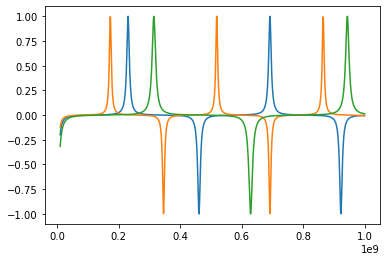

In [21]:
f_ = np.linspace(0.01e9, 1e9, 1601)
# s11 = sample.get_s21('p1', 'p1', f_)
s21 = sample.get_s21('pad-left-0', 'pad-right-0', f_)
s212 = sample.get_s21('pad-top-0', 'pad-top-2', f_)
s213 = sample.get_s21('pad-bottom-0', 'pad-bottom-2', f_)
#plt.plot(f_, np.angle(s21))
#plt.plot(f_, np.angle(s212))
#plt.plot(f_, np.angle(s213))
plt.plot(f_, s21)
plt.plot(f_, s212)
plt.plot(f_, s213)